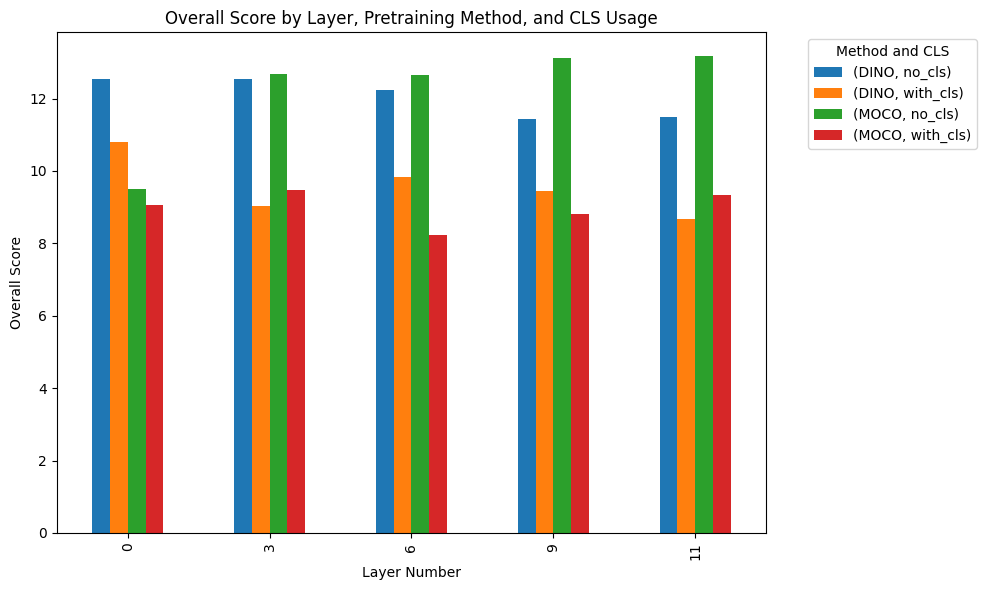

In [2]:
import glob
import json
import re
import pandas as pd
import matplotlib.pyplot as plt

# Load all JSON files
json_files = glob.glob('/Users/luisgilch/Desktop/analysis_intermediatelayers/*/results_summary.json')
records = []
for file in json_files:
    with open(file, 'r') as f:
        data = json.load(f)
    exp_name = data.get('experiment', '')
    
    # Parse experiment name: VIT16_{pretrain}_{...}
    parts = exp_name.split('_')
    pretrain = parts[1] if len(parts) > 1 else 'UNKNOWN'
    cls_flag = 'cls' in parts
    layer_match = re.search(r'layer(\d+)', exp_name)
    layer = int(layer_match.group(1)) if layer_match else None
    
    records.append({
        'layer': layer,
        'pretrain': pretrain,
        'cls': 'with_cls' if cls_flag else 'no_cls',
        'overall_score': data.get('overall_score', None)
    })

if not records:
    print("No JSON files loaded. Please check the path to your JSON result files.")
else:
    df = pd.DataFrame(records)
    pivot_df = df.pivot(index='layer', columns=['pretrain', 'cls'], values='overall_score').sort_index()
    fig, ax = plt.subplots(figsize=(10, 6))
    pivot_df.plot(kind='bar', ax=ax)
    ax.set_xlabel('Layer Number')
    ax.set_ylabel('Overall Score')
    ax.set_title('Overall Score by Layer, Pretraining Method, and CLS Usage')
    ax.legend(title='Method and CLS', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

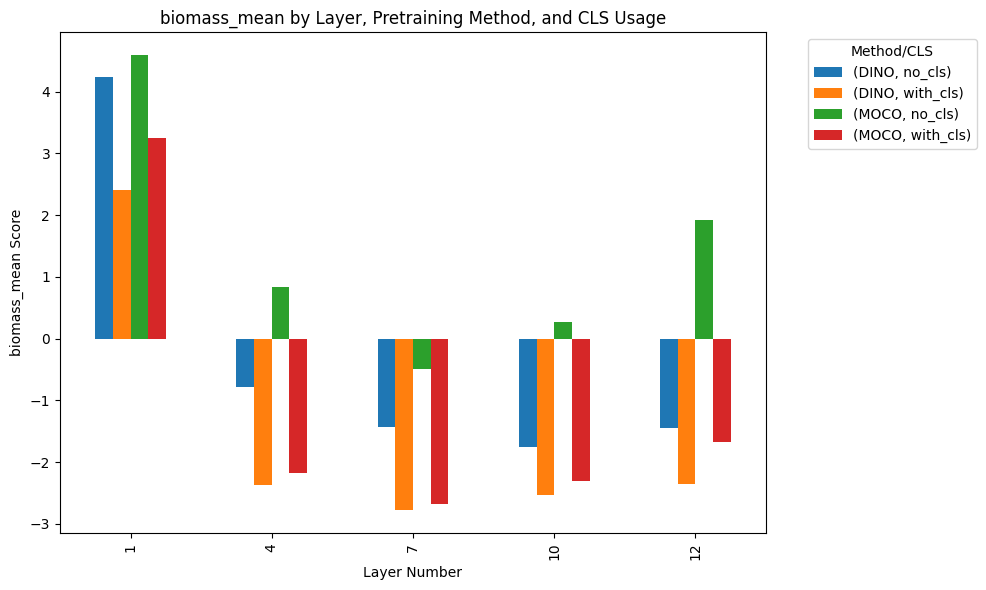

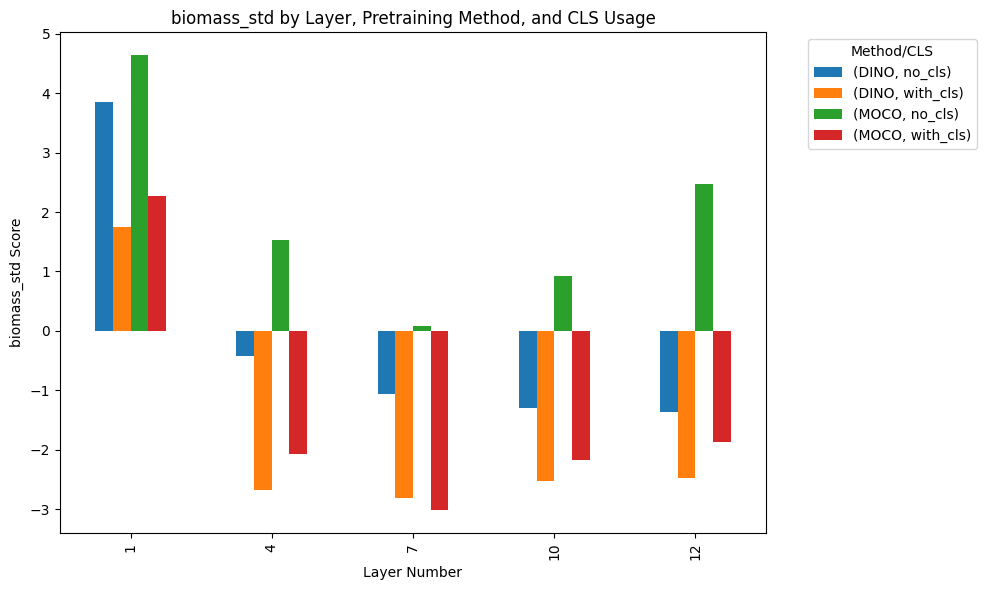

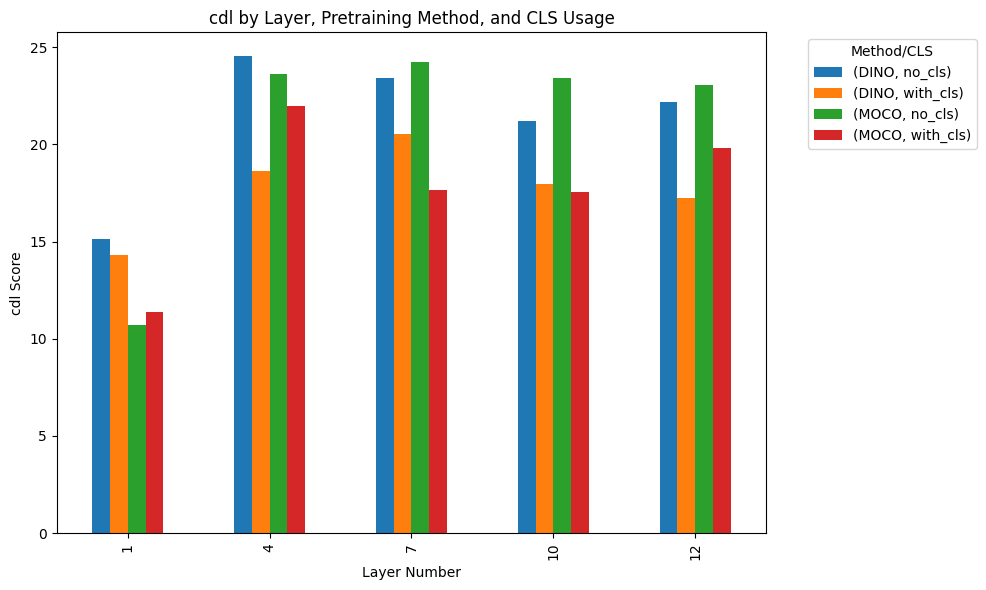

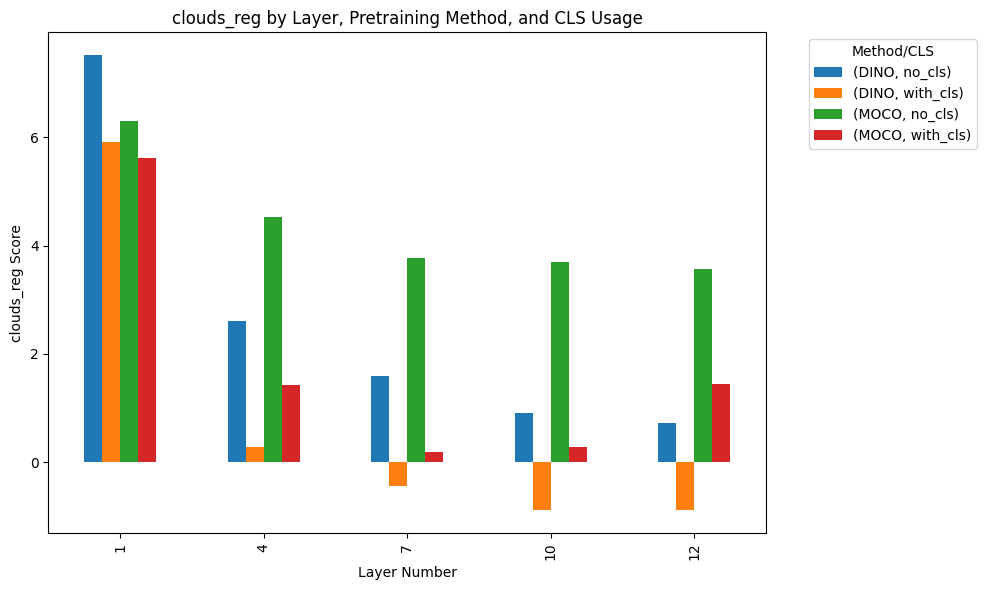

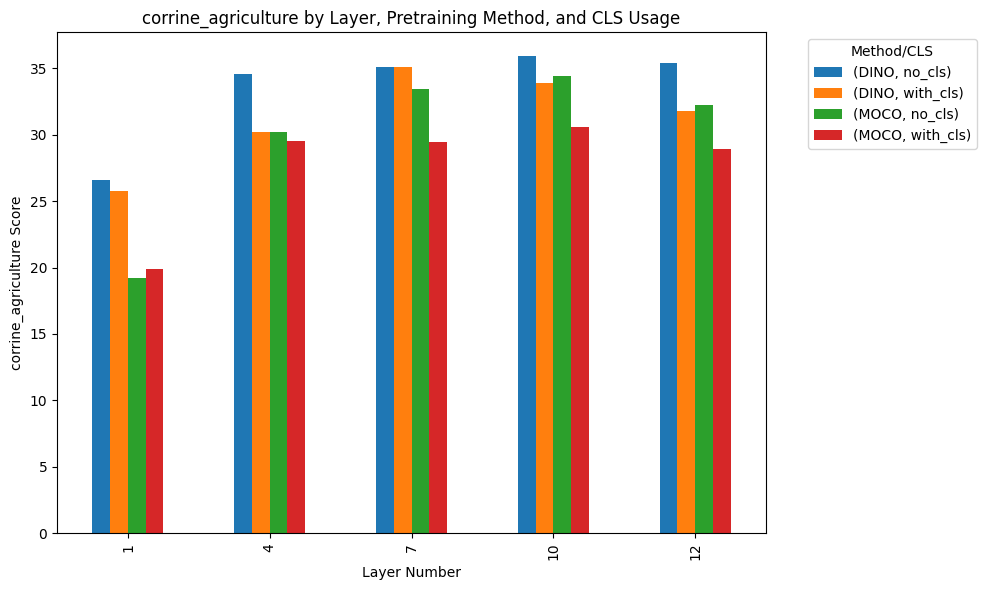

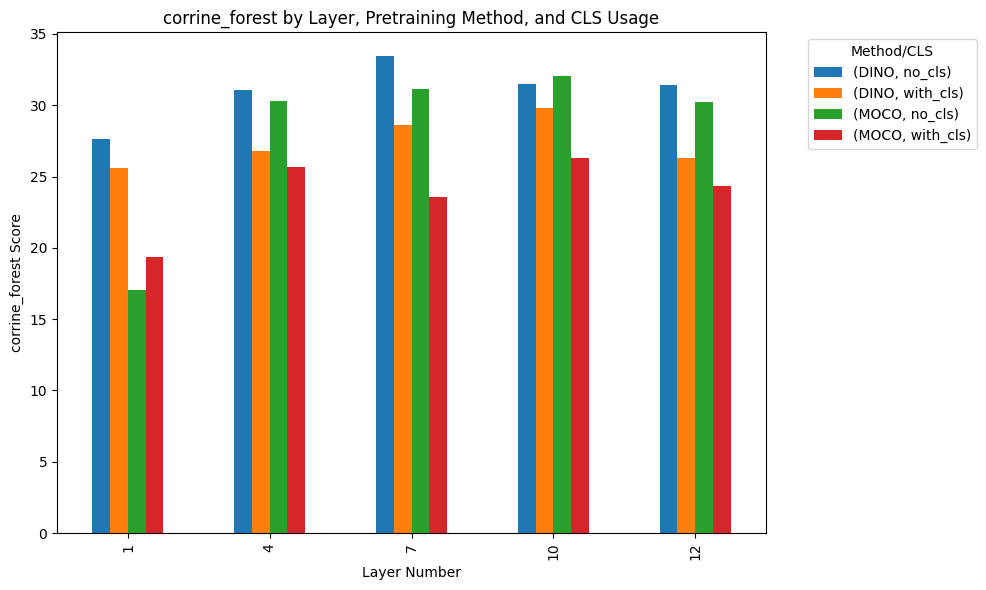

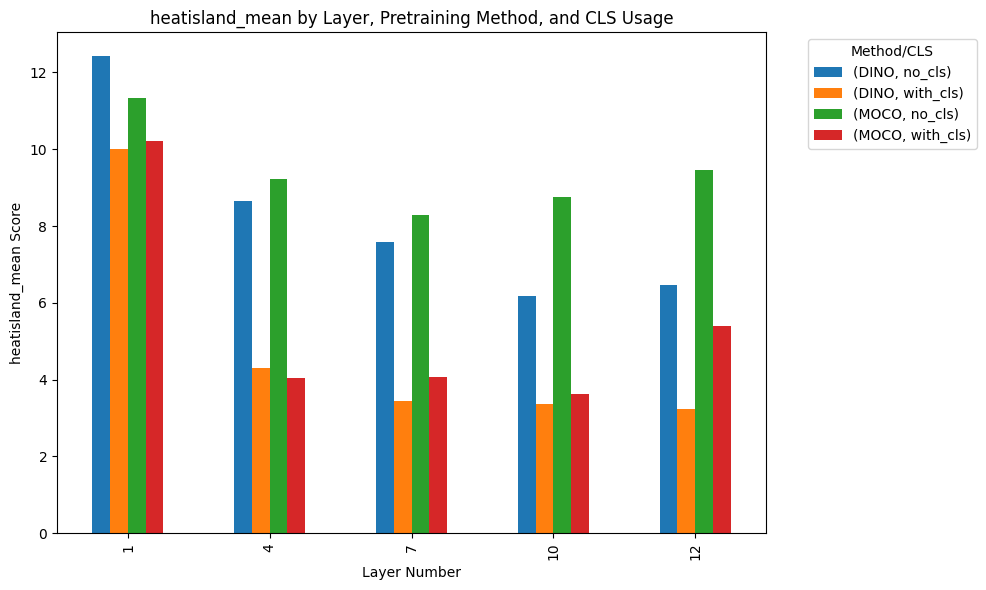

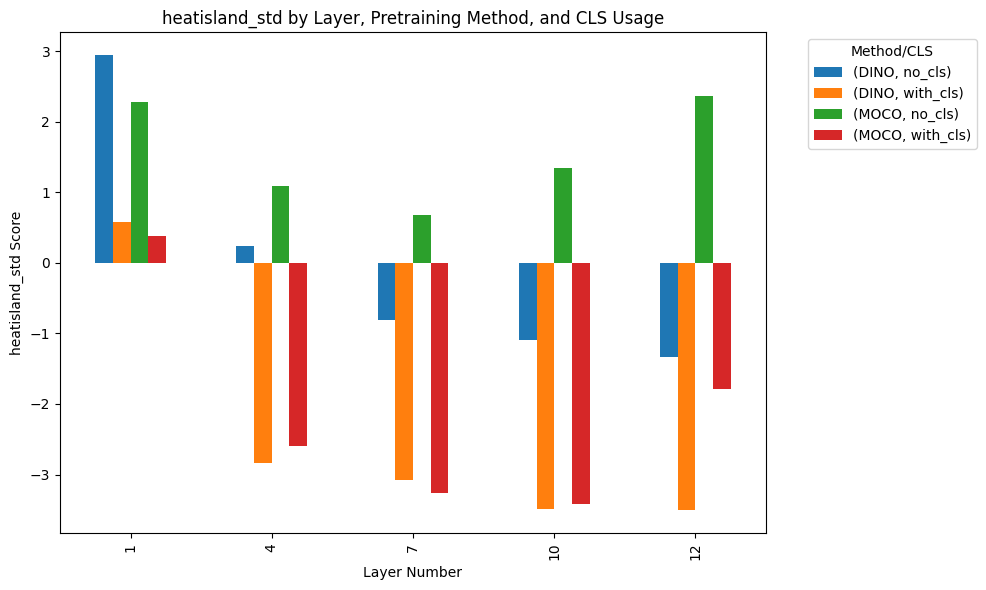

In [5]:
import glob
import json
import re
import pandas as pd
import matplotlib.pyplot as plt

# Adjust the base path as needed
json_files = glob.glob('/Users/luisgilch/Desktop/analysis_intermediatelayers/*/results_summary.json')

# Define the desired x-tick labels
xticks = [1, 4, 7, 10, 12]
xtick_labels = [str(x) for x in xticks]

records = []
for file in json_files:
    with open(file, 'r') as f:
        data = json.load(f)
    exp_name = data.get('experiment', '')
    parts = exp_name.split('_')
    pretrain = parts[1] if len(parts) > 1 else 'UNKNOWN'
    cls_flag = 'cls' in parts
    layer_match = re.search(r'layer(\d+)', exp_name)
    layer = int(layer_match.group(1)) if layer_match else None

    # Flatten each task result into separate records
    task_results = data.get('task_results', {})
    for task, score in task_results.items():
        records.append({
            'layer': layer,
            'pretrain': pretrain,
            'cls': 'with_cls' if cls_flag else 'no_cls',
            'task': task,
            'score': score
        })

if not records:
    print("No task records found. Check your path and JSON structure.")
else:
    df = pd.DataFrame(records)
    tasks = sorted(df['task'].unique())
    
    # Create one plot per downstream task
    for task in tasks:
        task_df = df[df['task'] == task]
        pivot_df = task_df.pivot(index='layer', columns=['pretrain','cls'], values='score').sort_index()
        
        fig, ax = plt.subplots(figsize=(10, 6))
        pivot_df.plot(kind='bar', ax=ax)
        ax.set_xlabel('Layer Number')
        ax.set_ylabel(f'{task} Score')
        ax.set_title(f'{task} by Layer, Pretraining Method, and CLS Usage')
        ax.set_xticklabels(xtick_labels)
        ax.legend(title='Method/CLS', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

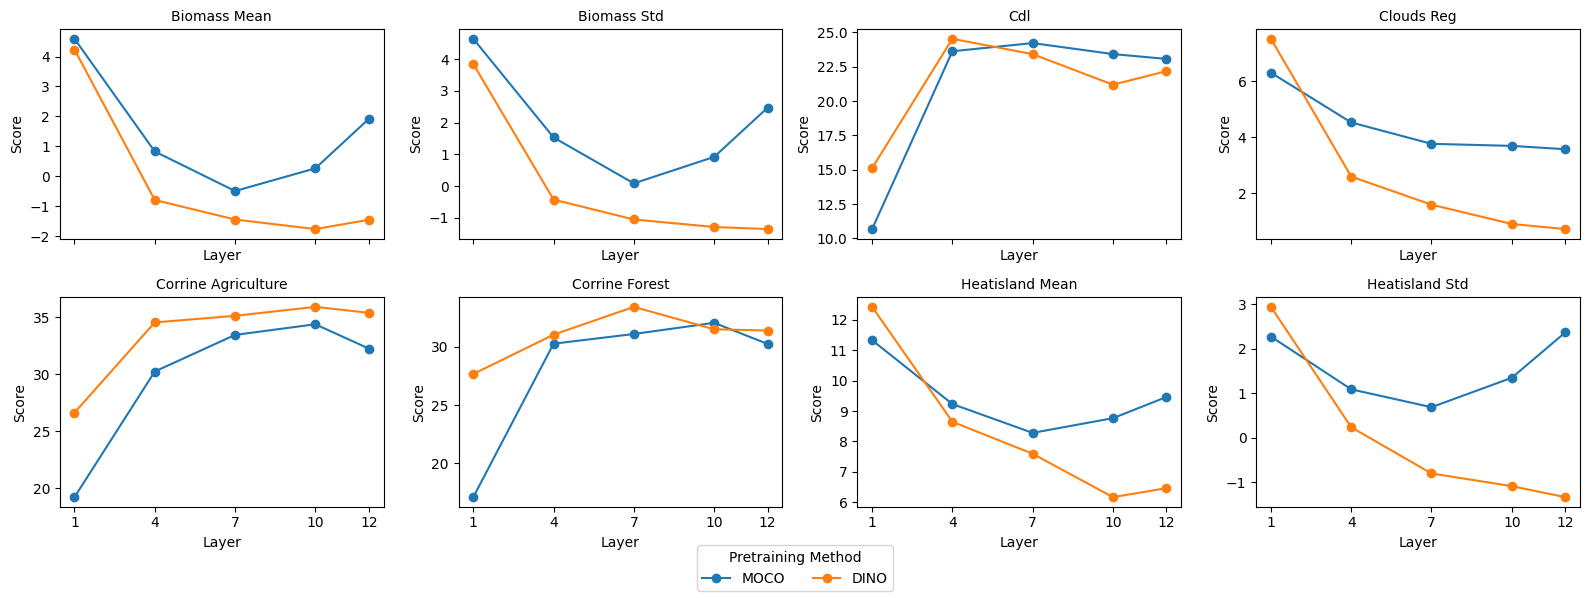

In [15]:
import glob, json, re, math
import pandas as pd
import matplotlib.pyplot as plt

# 1) Load & flatten your JSON summaries
json_files = glob.glob('/Users/luisgilch/Desktop/analysis_intermediatelayers/*/results_summary.json')
records = []
for fn in json_files:
    d = json.load(open(fn))
    exp = d['experiment']
    parts = exp.split('_')
    pre = parts[1]              # MOCO or DINO
    has_cls = 'cls' in parts
    layer = int(re.search(r'layer(\d+)', exp).group(1)) + 1

    for task, score in d['task_results'].items():
        records.append({
            'layer': layer,
            'pretrain': pre,
            'cls': 'with_cls' if has_cls else 'no_cls',
            'task': task,
            'score': score
        })

df = pd.DataFrame(records)

# 2) Filter out CLS-runs (since your paragraph focuses on patch-level only)
df = df[df.cls == 'no_cls']

# 3) Figure layout: 2 rows × 4 columns
tasks = sorted(df.task.unique())
n_cols = 4
n_rows = math.ceil(len(tasks)/n_cols)
fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(4*n_cols, 3*n_rows),
                         sharey=False, sharex=True)

# 4) Plot each task
xticks = [1,4,7,10,12]
for ax, task in zip(axes.flatten(), tasks):
    sub = df[df.task == task]
    for pre in ['MOCO','DINO']:
        seg = sub[sub.pretrain == pre].sort_values('layer')
        ax.plot(seg.layer, seg.score, marker='o', label=pre)
    ax.set_title(task.replace('_',' ').title(), fontsize=10)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)
    ax.set_xlabel('Layer')
    ax.set_ylabel('Score')

# 5) Hide any leftover axes
for ax in axes.flatten()[len(tasks):]:
    ax.axis('off')

# 6) One legend at bottom
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels,
           title='Pretraining Method',
           loc='lower center', ncol=2)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


In [11]:
#df.to_csv("vit16_results_layer.csv", index=False)